In [1]:
import os
import cv2
import math
import dlib
import PIL
import operator
import datetime
import itertools
import statistics
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from yellowbrick.classifier import ClassificationReport
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from imutils import face_utils
from sklearn.svm import SVC

In [4]:
# Declaration of functions
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def print_image(image,title=''):
    if verbosity==False:
        return
    figure = plt.figure()
    plt.title(title)
    plt.imshow(image)

def symmetry_deviation(shape):
    # calculate symmetry line of shape (left-right lines)
    (m1,b1,x_val,y_val) = left_right_symmetry_line(shape)
    reg_line = [(m1*x)+b1 for x in x_val]

    if verbosity==True:
        plt.plot(x_val,reg_line)

    # main symmetry line of shape (nose-chin line)
    (m2,b2,x_val,y_val) = main_symmetry_line(shape)
    reg_line = [(m2*x)+b2 for x in x_val]

    if verbosity==True:
        plt.plot(x_val,reg_line)
    
    # determin deviation of two lines
    err = abs(math.degrees(math.atan((m1-m2)/(1+m1*m2))))
    return err

def left_right_symmetry_line(shape):
    shape = shape.tolist()
    points = [ (21,22), (18,25), (36,45), (39,42), (31,35), (48,54), (50,52), (58,56), (5,11), (1,15), (3,13), (7,9) ]
    x_val = []
    y_val = []
    for item in points:
        left_point = shape[item[0]]
        right_point = shape[item[1]]
        (x,y) = line_centre(left_point,right_point)
        x_val.append(x)
        y_val.append(y)
        
    (m,b) = slope_interception(x_val,y_val)
    return m,b,x_val,y_val

def line_centre(x,y):
    return [int(round((x[0]+y[0])/2)),int(round((x[1]+y[1])/2))]

def slope_interception(x_val,y_val):
    x = np.array(x_val)
    y = np.array(y_val)
    m = ( ((np.mean(x)*np.mean(y)) - np.mean(x*y)) / ((np.mean(x)*np.mean(x)) - np.mean(x*x)) )
    m = round(m,2)
    b = (np.mean(y) - np.mean(x)*m)
    b = round(b,2)
    # y = m*x+b
    return m,b

def main_symmetry_line(shape):
    shape = shape.tolist()
    points = [27,27,29,30,33,51,62,66,57,8]
    x_val = []
    y_val = []
    for item in points:
        point = shape[item]
        x_val.append(point[0])
        y_val.append(point[1])
        
    (m,b) = slope_interception(x_val,y_val)
    return m,b,x_val,y_val

def golden_ratio(shape):
    GR = 1.62
    err_list = [] # sum of square errors
    
    # odnos debljina usne - sirina nosa
    x1 = get_lips_height(shape)
    x2 = get_nose_width(shape)
    err_list.append((GR-x1/x2)**2)
    
    # odnos sirina nosa i razmak usana od nosa
    x1 = get_nose_width(shape)
    mouth_centre = line_centre(shape[62],shape[66])
    x2 = euclidean_distance(shape[33][0],shape[33][1],mouth_centre[0],mouth_centre[1])
    err_list.append((GR-x1/x2)**2)
    
    # odnos razmaka od vrha nosa do brade i razmak usana od vrha brade
    x1 = euclidean_distance(shape[33][0],shape[33][1],shape[8][0],shape[8][1])
    x2 = euclidean_distance(shape[8][0],shape[8][1],mouth_centre[0],mouth_centre[1])
    err_list.append((GR-x1/x2)**2)
    
    # jednak odnos sirine ociju i sirine medjuocnog prostora
    x1 = euclidean_distance(shape[36][0],shape[36][1],shape[39][0],shape[39][1])
    x2 = euclidean_distance(shape[42][0],shape[42][1],shape[45][0],shape[45][1])
    eye_width = (x1+x2)/2
    x3 = get_eye_distance(shape)
    
    err = eye_width/x3
    if (err<0):
        err = x3/eye_width
    
    err_list.append(err**2)
    
    # jednak odnos po visini
    left_eye = line_centre(shape[36],shape[39])
    right_eye = line_centre(shape[42],shape[45])
    eyes = line_centre(left_eye,right_eye)
    
    x1 = euclidean_distance(shape[33][0],shape[33][1],eyes[0],eyes[1])
    x2 = euclidean_distance(shape[33][0],shape[33][1],shape[8][0],shape[8][1])
    
    err = x1/x2
    if (err<0):
        err = x2/x1
    
    err_list.append(err**2)
    
    return sum(err_list)

def get_nose_width(shape):
    shape = shape.tolist()
    high_point = shape[31]
    low_point = shape[35]
    return euclidean_distance(high_point[0],high_point[1],low_point[0],low_point[1])

def get_lips_height(shape):
    shape = shape.tolist()
    high_point = shape[51]
    low_point = shape[57]
    return euclidean_distance(high_point[0],high_point[1],low_point[0],low_point[1])

def get_eye_distance(shape):
    shape = shape.tolist()
    left_point = shape[39]
    right_point = shape[42]
    return euclidean_distance(left_point[0],left_point[1],right_point[0],right_point[1])

def euclidean_distance(x1,y1,x2,y2):
    return math.hypot(x2 - x1, y2 - y1)

def skin_wrinkles(shape,face_image):
    shape = shape.tolist()
    xmin = shape[42][0]
    ymax = shape[30][1]
    xmax = shape[45][0]
    ymin = shape[28][1]

    #cv2.rectangle(face_image,(xmin,ymin),(xmax,ymax),(0,255,0),3)
    #print_image(face_image,'skin wrinkles')
                
    skin = face_image[ymin:ymax, xmin:xmax]
    gray_skin = cv2.cvtColor(skin, cv2.COLOR_RGB2GRAY)
    
    v = np.median(gray_skin)
    sigma = 0.33    
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(gray_skin, lower, upper)
    
    white_pixels = np.sum(edged == 255)
    width,height = edged.shape
    total_pixels = width*height
    
    return (white_pixels/total_pixels)*100

def skin_redness(shape,face_image):
    shape = shape.tolist()
    xmin = shape[42][0]
    ymax = shape[30][1]
    xmax = shape[45][0]
    ymin = shape[28][1]
    
    skin = face_image[ymin:ymax, xmin:xmax]
    size = skin.size
    
    #print_image(skin, 'Skin redness 2')
    
    RED_MIN = np.array([0,0,128], np.uint8)
    RED_MAX = np.array([250, 250, 255], np.uint8)
    
    dstr = cv2.inRange(skin, RED_MIN, RED_MAX)
    no_red = cv2.countNonZero(dstr)
    frac_red = np.divide((float(no_red)),(int(size)))
    percent_red = frac_red*100
    
    return percent_red

def average(l): 
    return sum(l)/len(l)


In [24]:
matplotlib.rcParams['figure.figsize'] = 20,16


# Declaration of variables
verbosity=False
basewidth=320

image_list = {}
temp_list = {}

pos_list_redness = []
pos_list_wrinkles = []
pos_list_symmerty = []
pos_list_golden_ratio = []
neg_list_redness = []
neg_list_wrinkles = []
neg_list_symmerty = []
neg_list_golden_ratio = []

pos_features = []
neg_features = []
labels = []

image_dir_pos = 'slike/positive'
image_dir_neg = 'slike/negative'

print('\n*** An algorithm that extracts the features from face image and inserts them in SVM and KNN for \'smart\' detection of drug addicts ***')
start_time = datetime.datetime.utcnow()
print('\nProcess started at ', start_time,'\n')

# Algorithm 1: Download all images from the folder
for img_name in os.listdir(image_dir_pos):
    img_path = os.path.join(image_dir_pos, img_name)
    img = load_image(img_path)
    img_name = "pos_" + img_name
    image_list[img_name]=img
    
for img_name in os.listdir(image_dir_neg):
    img_path = os.path.join(image_dir_neg, img_name)
    img = load_image(img_path)
    img_name = "neg_" + img_name
    image_list[img_name]=img

# Algorithm 2: Image preprocessing
#for img_name in image_list:
#	img = image_list[img_name]
#	wpercent = (basewidth / float(img.shape[0]))
#	hsize = int((float(img.shape[1]) * float(wpercent)))
#	img = cv2.resize(img, (basewidth, hsize), PIL.Image.ANTIALIAS)
#	temp_list[img_name]=img
#
#image_list = temp_list

p = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(p)



*** An algorithm that extracts the features from face image and inserts them in SVM and KNN for 'smart' detection of drug addicts ***

Process started at  2019-08-17 22:48:10.295898 



In [25]:
for name in image_list:
    image = image_list[name]
    original = image.copy()
    features = []
    
    if verbosity==True:
        print('\nThe image being processed is ' + name)
    
    # Converting the image to gray scale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	# Algorithm 3: Face landmarks extraction
    rects = detector(gray, 0)

    # For each detected face, find the landmark.
    for (i, rect) in enumerate(rects):
        # Make the prediction and transfom it to numpy array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

    # Draw on our image, all the finded cordinate points (x,y) 
    for (x, y) in shape:
        cv2.circle(image, (x, y), 2, (0, 255, 0), -1)        
    
    # Show the image with landmarks
    print_image(image,name)
    
    # Algorithm 4: Symmetry of the face
    symmetry = symmetry_deviation(shape)
    if verbosity==True:
        print('Deviation from the Symmetry is ' + str(symmetry) + '° (less is better, ideally 0)')
    features.append(symmetry)

	# Algorithm 5: Golden ratio
    gr = golden_ratio(shape)
    if verbosity==True:
        print('The deviation from the Golden Ratio is ' + str(gr) + ' (less is better, ideally 1)')
    features.append(gr)
 
    # Algorithm 6: Skin wrinkles
    wrinkles = skin_wrinkles(shape,original)
    if verbosity==True:
        print('The percentage of wrinkles is ' + str(wrinkles) + '% (less is better, ideally 0)')
    features.append(wrinkles)
    
    # Algoritam 7: Skin redness
    redness = skin_redness(shape,original)
    if verbosity==True:
        print('The percentage of skin redness is ' + redness + '% (less is better, ideally 0)')
    features.append(redness)
    
    
    # Algorithm 8: Preparation for classification
    img_type = name.split("_", 1)[0]
    if (img_type=="pos"):
        pos_features.append(features)
        labels.append(1)
        pos_list_redness.append(redness)
        pos_list_wrinkles.append(wrinkles)
        pos_list_symmerty.append(symmetry)
        pos_list_golden_ratio.append(gr)
    else:
        neg_features.append(features)
        labels.append(0)
        neg_list_redness.append(redness)
        neg_list_wrinkles.append(wrinkles)
        neg_list_symmerty.append(symmetry)
        neg_list_golden_ratio.append(gr)

print('\nThe results (negative):')
print('The average deviation from the Symmetry is     ' + str(average(neg_list_symmerty)) + '° (less is better, ideally 0)')
print('The average deviation from the Golden Ratio is ' + str(average(neg_list_golden_ratio)) + ' (less is better, ideally 1)')
print('The average percentage of wrinkles is          ' + str(average(neg_list_wrinkles)) + '% (less is better, ideally 0)')
print('The average percentage of redness is           ' + str(average(neg_list_redness)) + '% (less is better, ideally 0)')

print('\nThe results (positive):')
print('The average deviation from the Symmetry is     ' + str(average(pos_list_symmerty)) + '° (less is better, ideally 0)')
print('The average deviation from the Golden Ratio is ' + str(average(pos_list_golden_ratio)) + ' (less is better, ideally 1)')
print('The average percentage of wrinkles is          ' + str(average(pos_list_wrinkles)) + '% (less is better, ideally 0)')
print('The average percentage of redness is           ' + str(average(pos_list_redness)) + '% (less is better, ideally 0)')



The results (negative):
The average deviation from the Symmetry is     5.442260684372674° (less is better, ideally 0)
The average deviation from the Golden Ratio is 2.2007531721213147 (less is better, ideally 1)
The average percentage of wrinkles is          2.112936532227858% (less is better, ideally 0)
The average percentage of redness is           13.960059382879313% (less is better, ideally 0)

The results (positive):
The average deviation from the Symmetry is     3.1618658817019893° (less is better, ideally 0)
The average deviation from the Golden Ratio is 2.401929398814241 (less is better, ideally 1)
The average percentage of wrinkles is          2.934147765635157% (less is better, ideally 0)
The average percentage of redness is           15.519719024995124% (less is better, ideally 0)


In [28]:
# Algorithm 8: Preparation for classification
pos_features = np.array(pos_features)
neg_features = np.array(neg_features)
x = np.vstack((pos_features, neg_features))
y = np.array(labels)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

end_prep_time = datetime.datetime.utcnow()

#  Algorithm 9: SVM classification
start_svm_time = datetime.datetime.utcnow()
svm = SVC(kernel='linear', probability=True) 
svm.fit(x_train, y_train)
y_train_pred = svm.predict(x_train)
y_test_pred = svm.predict(x_test)
print("\nSVM Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("SVM Validation accuracy: ", accuracy_score(y_test, y_test_pred))
end_svm_time = datetime.datetime.utcnow()

# Algorithm 10: KNN classification
knn = KNeighborsClassifier(n_neighbors=3)
knn = knn.fit(x_train, y_train)
y_train_pred = knn.predict(x_train)
y_test_pred = knn.predict(x_test)
print("\nKNN Train accuracy: ", accuracy_score(y_train, y_train_pred))
print("KNN Validation accuracy: ", accuracy_score(y_test, y_test_pred))


end_time = datetime.datetime.utcnow()
print('\nProcess ended at ', end_time)
print('The process lasted ', end_time-start_time)

print('\nThe preparation of images lasted ', end_prep_time-start_time)
print('The SVM classification of images lasted ', end_svm_time-start_svm_time)
print('The KNN classification of images lasted ', end_time-end_svm_time)



SVM Train accuracy:  0.616822429906542
SVM Validation accuracy:  0.6111111111111112

KNN Train accuracy:  0.7663551401869159
KNN Validation accuracy:  0.5185185185185185

Process ended at  2019-08-17 22:48:52.857543
The process lasted  0:00:42.561645

The preparation of images lasted  0:00:42.392117
The SVM classification of images lasted  0:00:00.156649
The KNN classification of images lasted  0:00:00.012808


In [29]:
class_names = ['negative', 'positive']
report = classification_report(y_test, y_test_pred, target_names = class_names)
print(report)

              precision    recall  f1-score   support

    negative       0.43      0.59      0.50        22
    positive       0.62      0.47      0.54        32

    accuracy                           0.52        54
   macro avg       0.53      0.53      0.52        54
weighted avg       0.55      0.52      0.52        54



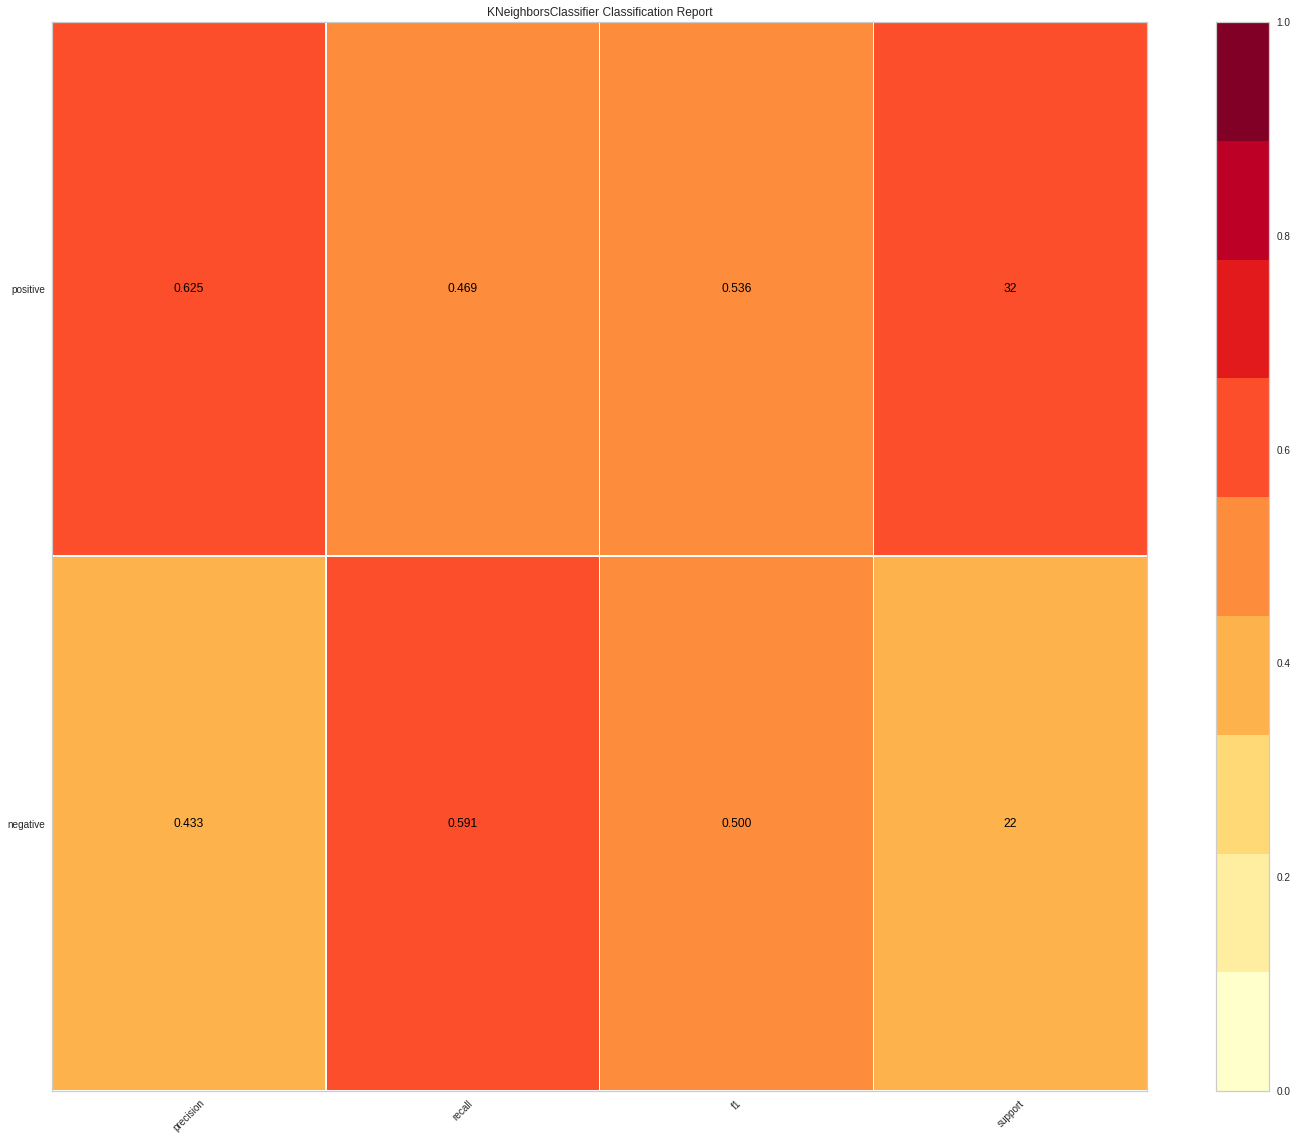

In [30]:
visualizer = ClassificationReport(knn, classes = class_names, support = True)
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
g = visualizer.poof()

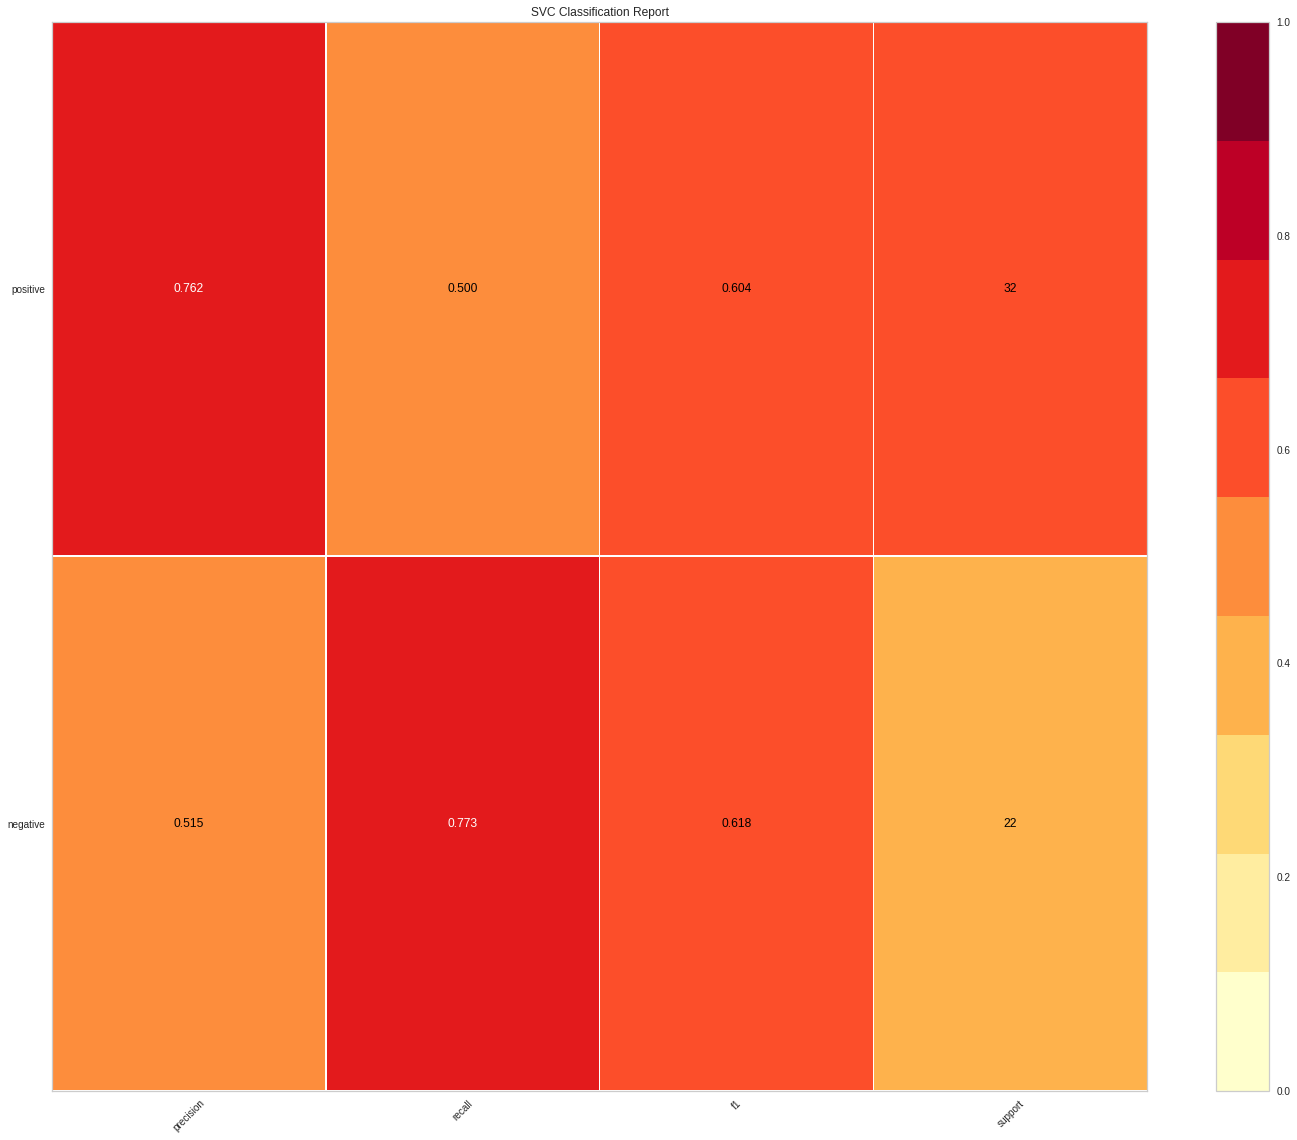

In [31]:
visualizer = ClassificationReport(svm, classes = class_names, support = True)
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
g = visualizer.poof()